# Week3 Two-way ANOVA
## 背景描述
工程师设计一种用在某装置内的电池，为了防止该装置遭受温度忽高忽低的极端变化，工程师需要选出一种材料使得不论温度高低都能使电池有较长的寿命。
工程师决定在 **3 个温度水平（15℉, 70℉, 125℉）** 上检验所有 **3 种板极材料**，这 3 种温度与产品使用的环境温度相符。  
在每种板极材料与温度组合上检验 **4 节电池**，依随机次序进行所有 36 次检验。   
这是一个材料（因子𝐴）水平数 $𝑎=3$，温度（因子𝐵）水平数 $𝑏=3$ 和重复次数 $𝑛=4$ 的双因子实验。

## 数据描述
| 变量名 | 变量含义 | 变量类型 | 变量取值范围 |
| :----------: | :--------: | :----------: | :----------: |
| （自变量）Material | 电池的板极材料 | categorical variable | [1, 2, 3] |
| （自变量）Temperature | 温度 | continuous variable(单位: ℉) | [15, 70, 125] |
| （因变量）Life | 电池的寿命 | continuous variable(单位: 小时) | $\mathbb{R}$ |

## 问题
这里使用 $\alpha=0.05$ 的水平
1. 试判断材料类型和温度对电池的寿命是否有显著影响；若有显著影响，则做多重比较.

2. 用适合的残差图来检验设定模型的恰当性.

3. 选出一种材料 使得不论温度高低都能使电池有较长的寿命（或者说尽量减少温度变化时电池寿命的损失）.

4. 估计参数$\mu$、$\tau_i$、$\beta_j$和$(\tau\beta)_{ij}\quad(i=1,...,a;j=1,...,b)$

5. 如何对电池寿命进行预测？

## 解决方案

**Q1:**  
检验行处理效应的等式假设:  $𝐻_{01}:\tau_1=\tau_2=\cdots=\tau_a=0$  vs  $𝐻_{11}:\tau_i \neq 0, \exists i$  
检验列处理效应的等式假设:  $𝐻_{02}:\beta_1=\beta_2=\cdots=\beta_b=0$  vs  $𝐻_{12}:\beta_j \neq 0, \exists j$  
检验行与列处理没有交互作用假设:  $𝐻_{03}:(\tau\beta)_{ij}=0, \forall i,j$  vs  $𝐻_{13}:(\tau\beta)_{ij} \neq 0, \exists i,j$  

In [1]:
# Import standard packages
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import math

# Import additional packages
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)

alpha = 0.05
a = 3
b = 3
n = 4

x = pd.read_csv('T5_1.csv')
data = x.values
df = pd.DataFrame(data, columns = ['Material', 'Temp', 'Life'])
print(df.head())

# Do the two-way ANOVA
model = ols('Life~ C(Material) + C(Temp) + C(Material):C(Temp)',df).fit()
anova_results = round(anova_lm(model), 4)
print('\n双因素方差分析表：\n', anova_results)

if anova_results['PR(>F)'][0] < 0.05:
    print('\nFor material, p-value: %f < 0.05, reject H01.'% anova_results['PR(>F)'][0])
else:
    print('\nFor material, accept H01.')

if anova_results['PR(>F)'][1] < 0.05:
    print('\nFor temperature, p-value: %f < 0.05, reject H02.'% anova_results['PR(>F)'][1])
else:
    print('\nFor temperature, accept H02.')
    
if anova_results['PR(>F)'][2] < 0.05:
    print('\nFor material:temp, p-value: %f < 0.05, reject H03.'% anova_results['PR(>F)'][2])
else:
    print('\nFor material:temp, accept H03.')

   Material  Temp  Life
0         1    15   130
1         1    15    74
2         1    15   155
3         1    15   180
4         1    70    34

双因素方差分析表：
                        df      sum_sq     mean_sq        F  PR(>F)
C(Material)           2.0  10683.7222   5341.8611   7.9114  0.0020
C(Temp)               2.0  39118.7222  19559.3611  28.9677  0.0000
C(Material):C(Temp)   4.0   9613.7778   2403.4444   3.5595  0.0186
Residual             27.0  18230.7500    675.2130      NaN     NaN

For material, p-value: 0.002000 < 0.05, reject H01.

For temperature, p-value: 0.000000 < 0.05, reject H02.

For material:temp, p-value: 0.018600 < 0.05, reject H03.


由上面的方差分析表可知，在$\alpha=0.05$的水平下：  
对板极材料来说，$p=0.0020<0.05$，所以板极材料对电池寿命有显著影响；  
对温度来说，$p=0.0000<0.05$，所以温度对电池寿命也具有显著影响；  
对板极材料和温度的交互因素来说，$p=0.0186<0.05$，所以俩交互因素对电池寿命也具有显著影响.

【多重比较】在双因子析因设计实验中，如果交互作用是显著的，一个因子（例如，因子 𝐴）的均值间的比较可能由于交互作用而模糊不清。
解决这类问题的方法是：将另一个因子（因子 𝐵）固定在一特定水平上，在此水平上对因子 𝐴 的均值使用 Tukey 检验法。  (多重比较)
由上面方差分析表可知，行均值、列均值和交互项均有显著性差异，所以下面我们进一步固定温度水平为 70℉，（举个例子）对 3 种材料进行多重比较，以Tukey的Honestly Significant Difference(HSD)检验法为例: 

固定温度水平为 70℉: 三种材料之间的多重比较: 
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
     1      2     62.5 0.0045  22.6325 102.3675   True
     1      3     88.5  0.001  48.6325 128.3675   True
     2      3     26.0 0.2175 -13.8675  65.8675  False
------------------------------------------------------




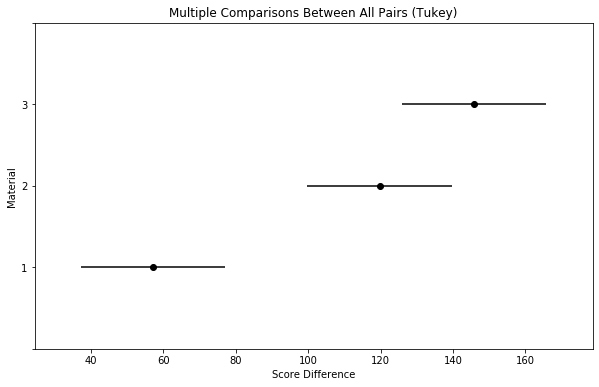

In [2]:
# 使用Tukey HSD 检验法进行多重比较
multiComp = MultiComparison(df.loc[df['Temp'] == 70, 'Life'], df.loc[df['Temp'] == 70, 'Material'])
tukey = multiComp.tukeyhsd()
print('固定温度水平为 70℉: 三种材料之间的多重比较: \n', tukey)

tukey.plot_simultaneous(ylabel= 'Material', xlabel= 'Score Difference')
print('\n')
# 横轴为得分代表电池寿命

结果说明：  
这一分析表明，当温度水平为 70℉ 时，材料类型 2 与类型 3 的电池平均寿命是相同的，而材料类型 1 的电池平均寿命显著地低于材料类型 2 与类型 3。

**Q2:**  
检验设定模型的恰当性：  
**残差分析0: 计算电池寿命数据的残差**

In [3]:
# 计算电池寿命数据的残差
list_temp = [15, 70, 125]
data_res = data.astype(float)
for i in range(a):
    for j in list_temp:
        cnt = data[(data[:,0] == i + 1) & (data[:,1] == j),2]
        data_res[(data_res[:,0] == i + 1) & (data_res[:,1] == j),2] = cnt-np.mean(cnt)
df = pd.DataFrame(data_res, columns = ['Material', 'Temp', 'Life_res'])
print(df.head())

   Material  Temp  Life_res
0       1.0  15.0     -4.75
1       1.0  15.0    -60.75
2       1.0  15.0     20.25
3       1.0  15.0     45.25
4       1.0  70.0    -23.25


**残差分析1: 残差的正态概率图** 

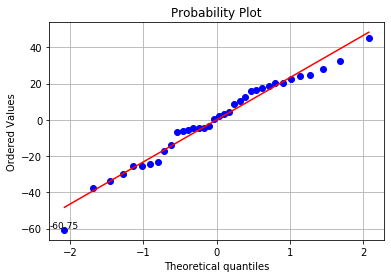

In [4]:
# 残差的正态概率图
res = data_res[:, 2]
osm, osr = stats.probplot(res, dist = 'norm', plot = plt)
x = osm[0][0]
y = osm[1][0]
plt.text(x, y, '%.2f' % float(y), ha='center', va= 'bottom', fontsize=9)
plt.grid()
plt.show()
# 在一条直线上就认为是近似一样的，除了一个异常值
# 用异常值检验检验是否是异常值

无特别的证据说明违背数据正态性；
异常值的检测：
$−60.75/\sqrt{675.21}=−2.34<−2$
绝对值大于 2 的残差，判断可能存在异常值。  
  
(计算标准化残差：$d_{ij} = \frac{e_{ij}}{\sqrt{MS_E}}$。一般地，标准化残差约 68% 落在 ±1 之内，约 95% 落在 ±2 之内，几乎全部落在 ±3 之内。标准化残差的绝对值大于3的残差是一个可能的异常值。)

In [5]:
#累积概率图 v.s. 正态概率图

In [6]:
# 用Shapiro-Wilk检验进行正态性检验
SW, pVal = stats.shapiro(res)
print(round(SW, 2))
print(round(pVal, 2))

if pVal > alpha:
    print('\nAccept the null hypothesis.')
else:
    print('\nSince p-value > 0.05, reject the null hypothesis') 

0.98
0.61

Accept the null hypothesis.


**残差分析2: 残差与预测值的关系图**  

Text(0, 0.5, 'e_ijk')

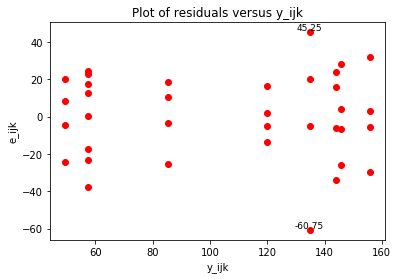

In [7]:
# 残差与预测值的关系图
y2 = []
for i in range(a):
    for j in list_temp:
        for k in range(n):
            y2.append(np.mean(data[(data[:,0] == i + 1) & (data[:,1] == j), 2]))
plt.scatter(y2, res, c = 'red')
plt.text(y2[0], res[1], '%.2f' % float(res[1]), ha='center', va= 'bottom', fontsize=9)
plt.text(y2[0], res[3], '%.2f' % float(res[3]), ha='center', va= 'bottom', fontsize=9)
plt.title('Plot of residuals versus y_ijk')
plt.xlabel('y_ijk')
plt.ylabel('e_ijk')

由上图可以看出，当电池寿命增加时，残差方差有微弱的增长趋势。

**残差分析3：残差与材料的关系图**  

Text(0, 0.5, 'e_ijk')

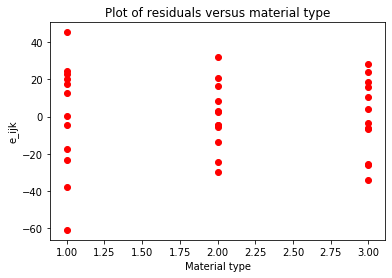

In [8]:
# 残差对材料种类的关系图
y3 = data_res[:,0]
plt.scatter(y3, res, c = 'red')
plt.title('Plot of residuals versus material type')
plt.xlabel('Material type')
plt.ylabel('e_ijk')

上图显示出方差微弱的不等性：材料类型为第一种时，比其他情况下方差大。

**残差分析4：残差与温度的关系图**  

Text(0, 0.5, 'e_ijk')

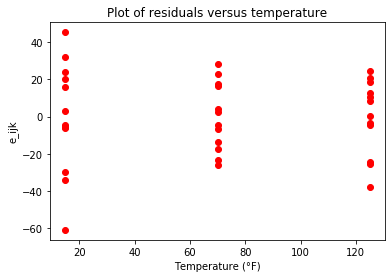

In [9]:
# 残差对温度的关系图
y4 = data_res[:,1]
plt.scatter(y4, res, c = 'red')
plt.title('Plot of residuals versus temperature')
plt.xlabel('Temperature (°F)')
plt.ylabel('e_ijk')

上图显示出方差微弱的不等性：温度为 15℉ 时，比其他情况下方差大。

在 15℉ 的温度-材料类型1 这一单元中，包含了两个极端残差值（-60.75 与 45.25）。这两个残差值对于后面三张图检验出的方差不等起了主要作用。重新审查这些数据，并未显出任何明显的问题，比如记录错误等，所有我们把这些响应作为真实数据接收下来。

**Q3:**  
为了选出一种材料，使得不论温度高低与否都能使电池有较长的寿命，我们进行固定效应模型分析。

In [10]:
# 固定效应模型分析
data_avg = data.astype(float) * 1
for i in range(a):
    for j in list_temp:
        cnt = data[(data[:,0] == i + 1) & (data[:,1] == j),2]
        data_avg[(data_avg[:,0] == i + 1) & (data_avg[:,1] == j),2] = np.mean(cnt)
df = pd.DataFrame(data_avg, columns = ['Material', 'Temperature', 'Life_avg'])
df



,Material,Temperature,Life_avg
0,1.0,15.0,134.75
1,1.0,15.0,134.75
2,1.0,15.0,134.75
3,1.0,15.0,134.75
4,1.0,70.0,57.25
5,1.0,70.0,57.25
6,1.0,70.0,57.25
7,1.0,70.0,57.25
8,1.0,125.0,57.50
9,1.0,125.0,57.50


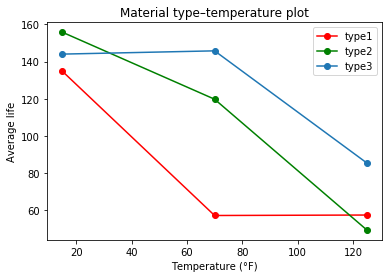

In [11]:
type1 = data_avg[[0,4,8], 2]
type2 = data_avg[[12,16,20], 2]
type3 = data_avg[[24,28,32], 2]
c1 = pd.Series(type1, index = list_temp, name = 'type1')
c2 = pd.Series(type2, index = list_temp, name = 'type2')
c3 = pd.Series(type3, index = list_temp, name = 'type3')
df = pd.concat([c1, c2, c3], axis = 1)

plt.plot(df.iloc[:,0], color = 'red', marker = 'o', label = 'type1')
plt.plot(df.iloc[:,1], color = 'green', marker = 'o', label = 'type2')
plt.plot(df.iloc[:,2], marker = 'o', label = 'type3')
plt.title('Material type–temperature plot')
plt.xlabel('Temperature (°F)')
plt.ylabel('Average life')
plt.legend(['type1', 'type2', 'type3'])

上图绘制了每一种处理组合的平均响应图，因为线段不平行，所以交互作用显著。一般来说，不管是什么材料，在低温处的寿命都较长。从低温变化至中等温度时，用材料类型 3 生产的电池的寿命实际上是增加的，而对类型 1 与类型 2 来说则是减少的。从中等温度变至高温时，用材料类型 2 与类型 3 生产的电池的寿命减少，而由类型 1 生产的电池的寿命不变。因此如果我们希望尽量减少温度变化时电池寿命的损失，材料类型 3 给出了最好的结果。 

**Q4:**  
估计参数$\mu$、$\tau_i$、$\beta_j$和$(\tau\beta)_{ij}\quad(i=1,...,a;j=1,...,b)$  
$\hat{\mu}=\bar{y}_{\cdots}$  
$\hat{\tau_i}=\bar{y}_{i\cdot\cdot}-\bar{y}_{\cdots},\quad i = 1,2,\cdots,a$  
$\hat{\beta_j}=\bar{y}_{\cdot j\cdot}-\bar{y}_{\cdots},\quad j = 1,2,\cdots,b$  
$\hat{\tau\beta}_{ij}=\bar{y}_{ij\cdot}-\bar{y}_{i\cdot\cdot}-\bar{y}_{\cdot j\cdot}+\bar{y}_{\cdots},\quad i = 1,2,\cdots,a\quad j = 1,2,\cdots,b$

In [12]:
# 参数估计
mu = np.mean(data[:,2])
print('总平均效应：', round(mu, 2))

tau = []
for i in range(a):
    tau.append(np.mean(data[data[:,0] == i + 1, 2]) - mu)
print('材料因子的水平效应：\n', np.round(tau, 2))

beta = []
for j in list_temp:
    beta.append(np.mean(data[data[:,1] == j, 2]) - mu)
print('温度因子的水平效应：\n', np.round(beta, 2))

tau_beta = []
k = 0
for i in range(a):
    tau_beta.append([])
    for j in range(b):
        cnt = data_avg[0 + 4 * k, 2] - tau[i] - beta[j] + mu
        tau_beta[i].append(cnt)
        k += 1
print('两因子之间的交互作用效应：\n', np.round(tau_beta, 2))



总平均效应： 105.53
材料因子的水平效应：
 [-22.36   2.81  19.56]
温度因子的水平效应：
 [ 39.31   2.06 -41.36]
两因子之间的交互作用效应：
 [[223.33 183.08 226.75]
 [219.17 220.42 193.58]
 [190.67 229.67 212.83]]


**Q5:**  
由于温度是定量的，而材料类型是定性的。再者，温度有 3 个水平。因此，我们可计算线性的和二次的温度效应，以便研究温度怎样影响电池寿命。  
这里我们画出响应曲线（response curve）可以得到响应变量与定量因子——温度的关系。一般地，线性回归方法可用于为实验数据拟合相应的模型。  
$Life = \beta_0+\beta_1A+\beta_2B_1+\beta_3B_2+\beta_4A^2+\beta_5AB_1+\beta_6AB_2+\beta_7A^2B_1+\beta_8A^2B_2$  
其中，分量 $A, A^2$ 分别表示温度因子的一次效应、二次效应，$B$ 表示材料类型因子的主效应。由于温度为低、中、高水平(15℉， 70℉ ， 125℉ )，对应的温度水平分别为 $A=-1，0，+1$。变量 $B[1]$ 和 $B[2]$ 被认为是示性变量（indicator variable），其定义为:  

|  | 1 | 2 | 3 |  
| :--------: | :--------: | :--------: | :---------: |  
| $B[1]$ |   1   |   0   |   -1   |  
| $B[2]$ |   0   |   1   |   -1   |

In [13]:
# 构造这 8 个变量
# list_A = [15, 70, 125]
list_A = [-1, 0, 1]
list_B1 = [1, 0, -1]
list_B2 = [0, 1, -1]
A = data[:,1] * 1
B1 = B2 = data[:, 0]
for i in range(3):
    A = [list_A[i] if j == list_temp[i] else j for j in A]
    B1 = [list_B1[i] if j == i + 1 else j for j in B1]
    B2 = [list_B2[i] if j == i + 1 else j for j in B2]
AA = [A[k] ** 2 for k in range(len(A))]
AB1 = [A[k] * B1[k] for k in range(len(A))]
AB2 = [A[k] * B2[k] for k in range(len(A))]
AAB1 = [AA[k] * B1[k] for k in range(len(A))]
AAB2 = [AA[k] * B2[k] for k in range(len(A))]
df = pd.DataFrame(A, columns = ['A'])
df['B1'] = B1
df['B2'] = B2
df['AA'] = AA
df['AB1'] = AB1
df['AB2'] = AB2
df['AAB1'] = AAB1
df['AAB2'] = AAB2
df['Life'] = data[:,2]
print(df.head())

# 训练模型
model = ols('Life~ A + B1 + B2 + AA + AB1 + AB2 + AAB1 + AAB2',df).fit()
param = model.params
model.summary()
# AAB1和AAB2一个显著一个不显著，这种交互效应是不能拿掉的(a-1)个潜变量有一个是显著的，那这种就不应该被代替
# AAB1和AAB2同生同死，表示温度的平方和B的关系，但只要有一项显著，它就是显著的。

   A  B1  B2  AA  AB1  AB2  AAB1  AAB2  Life
0 -1   1   0   1   -1    0     1     0   130
1 -1   1   0   1   -1    0     1     0    74
2 -1   1   0   1   -1    0     1     0   155
3 -1   1   0   1   -1    0     1     0   180
4  0   1   0   0    0    0     0     0    34


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Life   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     11.00
Date:                Wed, 17 Mar 2021   Prob (F-statistic):           9.43e-07
Time:                        14:55:00   Log-Likelihood:                -163.17
No. Observations:                  36   AIC:                             344.3
Df Residuals:                      27   BIC:                             358.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    107.5833      7.501     14.342      0.000      92.192     122.974
A            -40.3333      5.304     -7.604      0.000     -51.217     -29.450
B1           -50.3333     10.608     -4.745      0.000     -72.100     -28.567
B2            12.1667     10.608      1.147      0.261      -9.600      33.933
AA            -3.0833      9.187     -0.336      0.740     -21.934      15.767
AB1            1.7083      7.501      0.228      0.822     -13.683      17.099
AB2          -12.7917      7.501     -1.705      0.100     -28.183       2.599
AAB1          41.9583     12.992      3.229      0.003      15.300      68.617
AAB2         -14.0417     12.992     -1.081      0.289     -40.700      12.617
==============================================================================
Omnibus:                        1.609   Durbin-Watson:                   2.698
Prob(Omnibus):                  0.447   Jarque-Bera (JB):                1.192
Skew:                          -0.444   Prob(JB):                        0.551
Kurtosis:                       2.922   Cond. No.                         5.59
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

$Life = +107.58-40.33 *A-50.33 *B[1]+12.17 *B[2]-3.08 *A^2+1.71 *AB[1]-12.79 *AB[2]+41.96 *A^2B[1]-14.04A^2B[2]$

根据这个模型可以直接写出那三条曲线方程

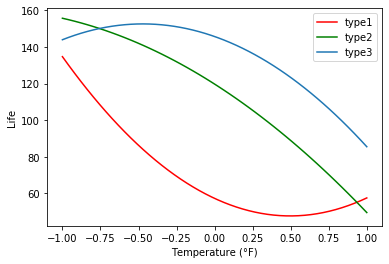

In [14]:
# 拟合响应曲线
# temp = np.linspace(15,125)
temp = np.linspace(-1, 1)
life_type1 = param[0] + param[1] * temp + param[2] * list_B1[0] + param[3] * list_B2[0] + param[4] * (temp ** 2) + param[5] * temp * list_B1[0] + param[6] * temp * list_B2[0] + param[7] * (temp ** 2) * list_B1[0] + param[8] * (temp ** 2) * list_B2[0]
life_type2 = param[0] + param[1] * temp + param[2] * list_B1[1] + param[3] * list_B2[1] + param[4] * (temp ** 2) + param[5] * temp * list_B1[1] + param[6] * temp * list_B2[1] + param[7] * (temp ** 2) * list_B1[1] + param[8] * (temp ** 2) * list_B2[1]
life_type3 = param[0] + param[1] * temp + param[2] * list_B1[2] + param[3] * list_B2[2] + param[4] * (temp ** 2) + param[5] * temp * list_B1[2] + param[6] * temp * list_B2[2] + param[7] * (temp ** 2) * list_B1[2] + param[8] * (temp ** 2) * list_B2[2]

c1 = pd.Series(life_type1, index = temp, name = 'type1')
c2 = pd.Series(life_type2, index = temp, name = 'type2')
c3 = pd.Series(life_type3, index = temp, name = 'type3')
df = pd.concat([c1, c2, c3], axis = 1)

plt.plot(df.iloc[:,0], color = 'red', label = 'type1')
plt.plot(df.iloc[:,1], color = 'green', label = 'type2')
plt.plot(df.iloc[:,2], label = 'type3')
plt.xlabel('Temperature (°F)')
plt.ylabel('Life')
plt.legend(['type1', 'type2', 'type3'])
# 这里数据标准化/中心化后模型的影响 
# 通过编码方式和非编码方式得到曲线不同
# 编码很像标准化的一种变换

拟合曲线[-1, 1]：  
材料类型为 1：  
$y =57.25 − 38.62 ∗ Temp + 38.88 ∗ Temp^2 $  
材料类型为 2：  
$y = 119.75 − 53.12 ∗ Temp − 17.12 ∗ Temp^2$  
材料类型为 3：  
$y = 145.74 - 29.25 ∗ Temp − 31 ∗ Temp^2$  
  
拟合曲线[15, 125]：  
材料类型为 1：  
$y = 169.38 − 2.50 ∗ Temp + 0.013 ∗ Temp^2 $   
材料类型为 2：  
$y = 159.62 − 0.17 ∗ Temp − 0.0057 ∗ Temp^2$  
材料类型为 3：  
$y = 132.76 + 0.90 ∗ Temp − 0.010 ∗ Temp^2$  
上图显示了这 3 个预测公式声称的响应曲线。 



## 第三周练习题
数据集：Project3.csv(内附文档)  
统计方法：Two-way ANOVA    
软件：Jupyter Notebook  
作业发到邮箱：51205903029@stu.ecnu.edu.cn  
压缩包名字：学号-姓名  
Deadline：下周一晚上10：00之前交  
注：要有完整的解题过程，不能只有代码